In [42]:
import os
import cv2
from PIL import Image 
import numpy as np 
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt
import random

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

minmaxscaler = MinMaxScaler()

#### Image Segmentation  
dataset: https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery

Building: #3C1098  
Land (unpaved area): #8429F6  
Road: #6EC1E4  
Vegetation: #FEDD3A  
Water: #E2A929  
Unlabeled: #9B9B9B  

![title](Images/Folder_structure_segm.png)

| Satellite Image             |  Mask |
|-------------------------|-------------------------|
![sat_img](Datasets/Segmentation_Tasks/Semantic%20segmentation%20dataset/Tile%201/images/image_part_009.jpg) | ![mask_img](Datasets/Segmentation_Tasks/Semantic%20segmentation%20dataset/Tile%201/masks/image_part_009.png)
![sat_img](Datasets/Segmentation_Tasks/Semantic%20segmentation%20dataset/Tile%205/images/image_part_007.jpg) | ![mask_img](Datasets/Segmentation_Tasks/Semantic%20segmentation%20dataset/Tile%205/masks/image_part_007.png)

In [5]:
dataset_root = 'Datasets/Segmentation_Tasks/Semantic segmentation dataset'

In [6]:
image = cv2.imread(f'{dataset_root}/Tile 2/images/image_part_001.jpg',1)

In [7]:
image.shape

(544, 509, 3)

In [9]:
# patchfy can split images into small overlappable patches by given patch cell size, and merge patches into original image.
# This will split the image into small images of shape [3,3]
image_patch_size = 256
image_patches = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
len(image_patches)

2

Break large images into smaller patches and normalize them, to ensure the dataset is ready for patch-based processing and semantic segmentation.  

For image patches:  
- Min-max normalization is applied using minmaxscaler.
- Each normalized patch is stored in image_dataset.
  
For mask patches:  
- Patches are directly stored in mask_dataset.

In [12]:
# Store processed image patches in arrays
image_dataset = []
mask_dataset = []

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
      
  elif image_type == 'masks':
     image_extension = 'png'
      
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
        
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        # Dimensions are cropped to the nearest multiple of image_patch_size for both width and height  
        size_x = (image.shape[1]//image_patch_size) * image_patch_size
        size_y = (image.shape[0]//image_patch_size) * image_patch_size
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        image = np.array(image)
        # Divide into smaller patches of size
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
          
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            # Scale between 0 and 1
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              image_dataset.append(individual_patched_image)
                
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)

In [13]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

(-0.5, 255.5, 255.5, -0.5)

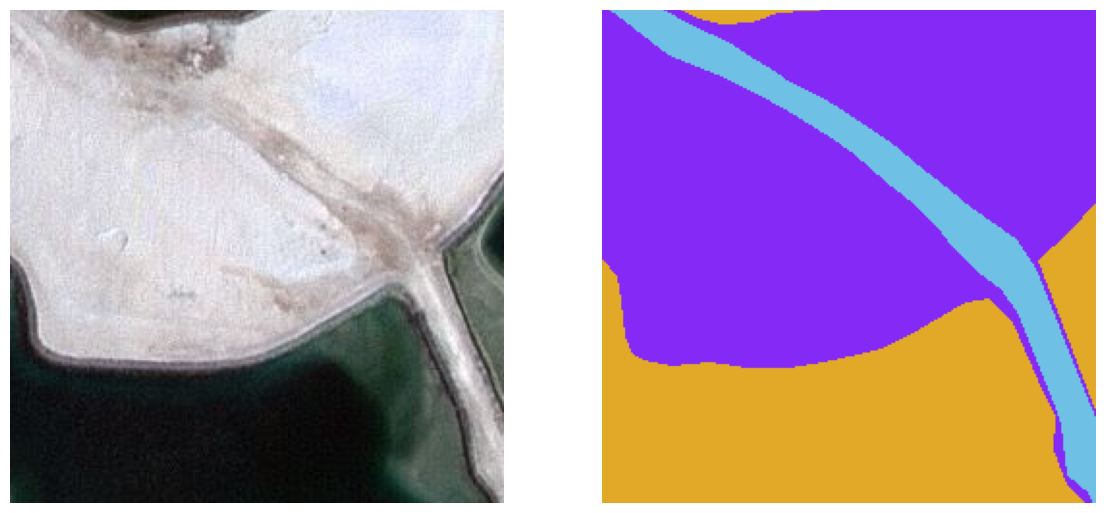

In [25]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.axis('off')
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])
plt.axis('off')

One-hot encoding using classes.json  

Each class e.g., building, land, road is represented by a specific color. During one-hot encoding of mask images, these RGB values can be used to identify pixels corresponding to each class and map them to class indices or binary masks.  

Extract the red ('3C'), green ('10'), and blue ('98') values and converts them to integers using int(hex, 16).  
The output for each class is an array of three integers, each representing the RGB values.

In [18]:
# One-hot encoding
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [19]:
label = individual_patched_mask

Models expect masks in the form of class indices (e.g., 0 for water, 1 for land).  
For example:  
[226, 169, 41] corresponds to class 0 (water),  
[155, 155, 155] corresponds to class 5 (unlabeled),  
[254, 221, 58] corresponds to class 4 (vegetation),  
[110, 193, 228] corresponds to class 2 (road)

In [33]:
def rgb_to_label(label):
    '''
    The function translates human-readable RGB masks into numerical format required for training and evaluation.
    Args:
    label: An RGB-encoded mask image, where each pixel has an RGB value corresponding to a specific class (e.g., buildings, water, etc.).
    '''
    label_segment = np.zeros(label.shape, dtype=np.uint8)
    label_segment[np.all(label == class_water, axis=-1)] = 0
    label_segment[np.all(label == class_land, axis=-1)] = 1
    label_segment[np.all(label == class_road, axis=-1)] = 2
    label_segment[np.all(label == class_building, axis=-1)] = 3
    label_segment[np.all(label == class_vegetation, axis=-1)] = 4
    label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
      
    label_segment = label_segment[:,:,0]
      
    return label_segment

In [29]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [34]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [35]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

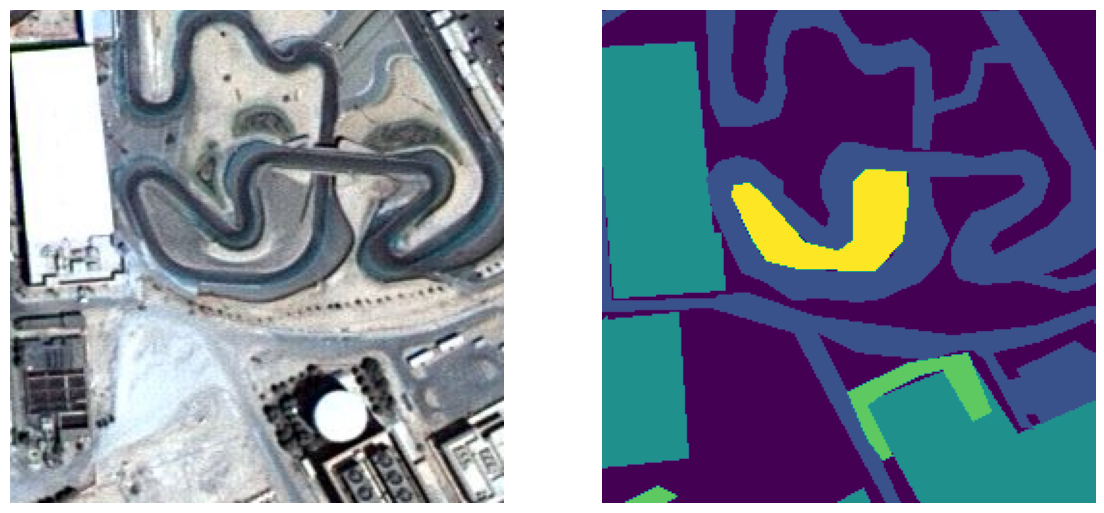

In [39]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.axis('off')
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.axis('off')
plt.imshow(labels[random_image_id][:,:,0])

In [40]:
total_classes = len(np.unique(labels))
total_classes

6

In [44]:
labels_cat_dataset = to_categorical(labels, num_classes = total_classes)
training_dataset = image_dataset

X_train, X_test, y_train, y_test = train_test_split(training_dataset, labels_cat_dataset, test_size=0.15, random_state=100)

In [46]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)
256
256
3
6
